<a href="https://colab.research.google.com/github/jscienciadados/detecta-spam/blob/main/Deteccao_Spam_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecção de Spams Usando R

## Instalação do Pacotes

In [2]:
# Pacotes
install.packages("slam", dependencies = T)
install.packages("tm", dependencies = T)
install.packages("SnowballC", dependencies = T)
install.packages("wordcloud", dependencies = T)
install.packages("gmodels", dependencies = T)
install.packages("e1071",dependencies = T)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“dependencies ‘Rcampdf’, ‘Rgraphviz’, ‘tm.lexicon.GeneralInquirer’ are not available”
also installing the dependencies ‘qpdf’, ‘NLP’, ‘antiword’, ‘filehash’, ‘pdftools’, ‘Rpoppler’, ‘SnowballC’


Warning message in install.packages("tm", dependencies = T):
“installation of package ‘Rpoppler’ had non-zero exit status”
Warning message in install.packages("tm", dependencies = T):
“installation of package ‘pdftools’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘caTools’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘gdata’, ‘gplots’, ‘gtools’, ‘lme4’


In

In [3]:
library(tm)
library(SnowballC)
library(wordcloud)
library(e1071)
library(gmodels)


Loading required package: NLP

Loading required package: RColorBrewer



## Carregando os Dados

In [4]:
dados <- read.csv("sms_spam.csv", stringsAsFactors = FALSE)

Examinando a estrutura dos dados

In [5]:
str(dados)

'data.frame':	5559 obs. of  2 variables:
 $ type: chr  "ham" "ham" "ham" "spam" ...
 $ text: chr  "Hope you are having a good week. Just checking in" "K..give back my thanks." "Am also doing in cbe only. But have to pay." "complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline "| __truncated__ ...


Convertendo para o tipo factor o conjunto de dados

In [7]:
dados$type <- factor(dados$type)
print(str(dados$type))
print("-----------------------------")
table(dados$type)

 Factor w/ 2 levels "ham","spam": 1 1 1 2 2 1 1 1 2 1 ...
NULL
[1] "-----------------------------"



 ham spam 
4812  747 

Construindo um corpus -> conjunto de documentos

In [8]:
dados_corpus <- VCorpus(VectorSource(dados$text))

Examinando a estrutura dos dados

In [9]:
print(dados_corpus)

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 5559


In [10]:
inspect(dados_corpus[1:2])

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 49

[[2]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 23



## Limpeza do corpus com tm_map()
help da função -> ?tm_map

In [12]:
dados_corpus_clean <- tm_map(dados_corpus, content_transformer(tolower))

Diferenças entre o corpus inicial e o corpus após a limpeza -> com a limpeza transformamos tudo para minusculo.

In [13]:
as.character(dados_corpus[[1]])
print("---------------------------------------")
as.character(dados_corpus_clean[[1]])

[1] "Hope you are having a good week. Just checking in"

[1] "---------------------------------------"


[1] "hope you are having a good week. just checking in"

Outras Etapa de Limpeza

In [14]:
dados_corpus_clean <- tm_map(dados_corpus_clean, removeNumbers) # remove números
dados_corpus_clean <- tm_map(dados_corpus_clean, removeWords, stopwords()) # remove stop words
dados_corpus_clean <- tm_map(dados_corpus_clean, removePunctuation) # remove pontuação

## Função para substituir ao invés de remover pontuação.

In [15]:
removePunctuation("hello...world")
replacePunctuation <- function(x) { gsub("[[:punct:]]+", " ", x) }
replacePunctuation("hello...world")

[1] "helloworld"

[1] "hello world"

## Word Stemming
?worStem

In [16]:
wordStem(c("learn", "learned", "learning", "learns"))

[1] "learn" "learn" "learn" "learn"

## Aplicando Stem

In [17]:
dados_corpus_clean <- tm_map(dados_corpus_clean, stemDocument)

Eliminando espeço em branco

In [18]:
dados_corpus_clean <- tm_map(dados_corpus_clean, stripWhitespace)

Examinando a versão final do corpus

In [19]:
lapply(dados_corpus[1:3], as.character)
print("-----------------------------------------------")
lapply(dados_corpus_clean[1:3], as.character)

$`1`
[1] "Hope you are having a good week. Just checking in"

$`2`
[1] "K..give back my thanks."

$`3`
[1] "Am also doing in cbe only. But have to pay."

[1] "-----------------------------------------------"


$`1`
[1] "hope good week just check"

$`2`
[1] "kgive back thank"

$`3`
[1] "also cbe pay"

## Criando uma Matriz Esparsa -> document-term
?DocumentTermMatrix

In [20]:
dados_dtm <- DocumentTermMatrix(dados_corpus_clean)

# Matriz Esparsa  - usando stop words customizadas a partir da função

In [21]:
dados_dtm3 <- DocumentTermMatrix(dados_corpus, control = list(tolower = TRUE,
                                                              removeNumbers = TRUE,
                                                              stopwords = function(x) { removeWords(x, stopwords()) },
                                                              removePunctuation = TRUE,
                                                              stemming = TRUE))


In [22]:
dados_dtm

<<DocumentTermMatrix (documents: 5559, terms: 6559)>>
Non-/sparse entries: 42147/36419334
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

In [23]:
dados_dtm3

<<DocumentTermMatrix (documents: 5559, terms: 6559)>>
Non-/sparse entries: 42147/36419334
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

## Criando dados de treino e de teste

In [24]:
dados_dtm_train <- dados_dtm[1:4169, ]
dados_dtm_test  <- dados_dtm[4170:5559, ]

Labels -> variavel targe

In [25]:
dados_train_labels <- dados[1:4169, ]$type
dados_test_labels  <- dados[4170:5559, ]$type

Verificando se a proporção de Spam é Similar

In [26]:
prop.table(table(dados_train_labels))
prop.table(table(dados_test_labels))


dados_train_labels
      ham      spam 
0.8647158 0.1352842 

dados_test_labels
      ham      spam 
0.8683453 0.1316547 

## Word Cloud

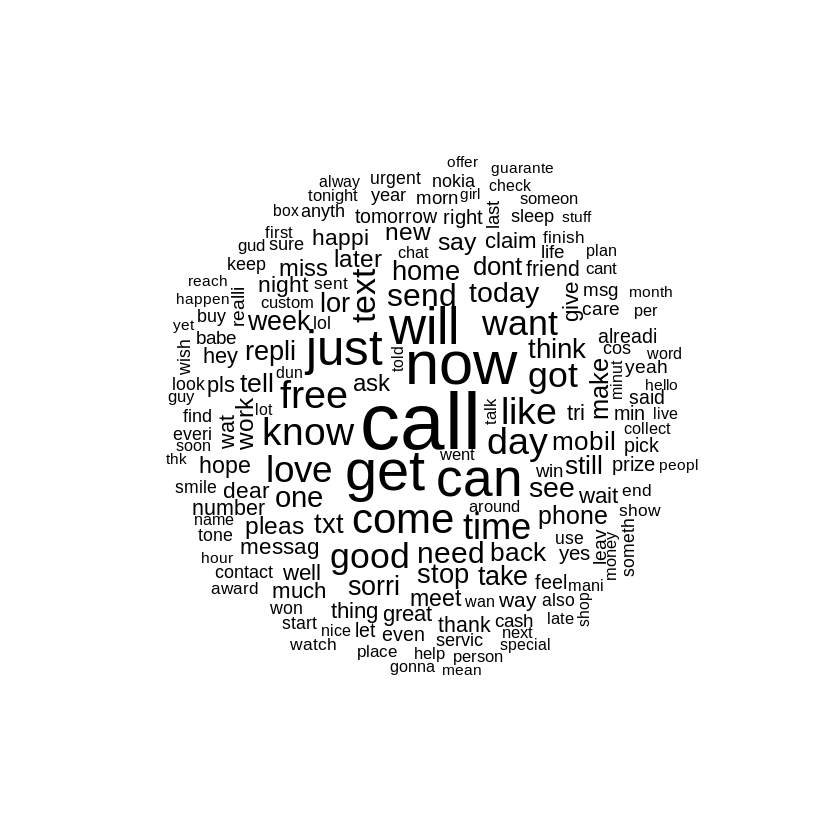

In [27]:
wordcloud(dados_corpus_clean, min.freq = 50, random.order = FALSE)

## Frequencia dos Dados

In [28]:
sms_dtm_freq_train <- removeSparseTerms(dados_dtm_train, 0.999)
sms_dtm_freq_train

<<DocumentTermMatrix (documents: 4169, terms: 1104)>>
Non-/sparse entries: 24827/4577749
Sparsity           : 99%
Maximal term length: 19
Weighting          : term frequency (tf)

## Indicador de Features para palavras frequentes

In [29]:
findFreqTerms(dados_dtm_train, 5)

[1] "£wk"                 "€˜m"                 "€˜s"                
   [4] "abiola"              "abl"                 "abt"                
   [7] "accept"              "access"              "account"            
  [10] "across"              "act"                 "activ"              
  [13] "actual"              "add"                 "address"            
  [16] "admir"               "adult"               "advanc"             
  [19] "aft"                 "afternoon"           "age"                
  [22] "ago"                 "aha"                 "ahead"              
  [25] "aight"               "aint"                "air"                
  [28] "aiyo"                "alex"                "almost"             
  [31] "alon"                "alreadi"             "alright"            
  [34] "also"                "alway"               "angri"              
  [37] "announc"             "anoth"               "answer"             
  [40] "anymor"              "anyon"               "anyth"              
  [43] "anytim"              "anyway"              "apart"              
  [46] "app"                 "appli"               "appreci"            
  [49] "arcad"               "ard"                 "area"               
  [52] "argu"                "argument"            "armand"             
  [55] "around"              "arrang"              "arriv"              
  [58] "asap"                "ask"                 "askd"               
  [61] "attempt"             "auction"             "avail"              
  [64] "ave"                 "avoid"               "await"              
  [67] "awak"                "award"               "away"               
  [70] "awesom"              "babe"                "babi"               
  [73] "back"                "bad"                 "bag"                
  [76] "bank"                "bare"                "basic"              
  [79] "bath"                "batteri"             "bcoz"               
  [82] "bday"                "beauti"              "becom"              
  [85] "bed"                 "bedroom"             "beer"               
  [88] "begin"               "believ"              "best"               
  [91] "better"              "bid"                 "big"                
  [94] "bill"                "bird"                "birthday"           
  [97] "bit"                 "black"               "blank"              
 [100] "bless"               "blue"                "bluetooth"          
 [103] "bold"                "bonus"               "boo"                
 [106] "book"                "boost"               "bore"               
 [109] "boss"                "bother"              "bout"               
 [112] "box"                 "boy"                 "boytoy"             
 [115] "break"               "breath"              "bring"              
 [118] "brother"             "bslvyl"              "btnationalr"        
 [121] "buck"                "bus"                 "busi"               
 [124] "buy"                 "cabin"               "call"               
 [127] "caller"              "callertun"           "camcord"            
 [130] "came"                "camera"              "campus"             
 [133] "can"                 "cancel"              "cancer"             
 [136] "cant"                "car"                 "card"               
 [139] "care"                "carlo"               "case"               
 [142] "cash"                "cashbal"             "catch"              
 [145] "caus"                "celebr"              "cell"               
 [148] "centr"               "chanc"               "chang"              
 [151] "charg"               "chat"                "cheap"              
 [154] "cheaper"             "check"               "cheer"              
 [157] "chennai"             "chikku"              "childish"           
 [160] "children"            "choic"               "choos"              
 [163] "christma"            "claim"               "class"   

In [30]:
# save frequently-appearing terms to a character vector
sms_freq_words <- findFreqTerms(dados_dtm_train, 5)
str(sms_freq_words)

 chr [1:1139] "£wk" "€˜m" "€˜s" "abiola" "abl" "abt" "accept" "access" ...


# Criando subsets apenas com palavras mais frequentes

In [31]:

sms_dtm_freq_train <- dados_dtm_train[ , sms_freq_words]
sms_dtm_freq_test <- dados_dtm_test[ , sms_freq_words]

In [32]:
# Converte para fator
convert_counts <- function(x) {
  print(x)
  x <- ifelse(x > 0, "Yes", "No")
}

In [33]:
# apply() converte counts para colunas de dados de treino e de teste
sms_train <- apply(sms_dtm_freq_train, MARGIN = 2, convert_counts)
sms_test  <- apply(sms_dtm_freq_test, MARGIN = 2, convert_counts)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Treinando o modelo
?naiveBayes

In [34]:
nb_classifier <- naiveBayes(sms_train, dados_train_labels)

# Avaliando o modelo

In [35]:
sms_test_pred <- predict(nb_classifier, sms_test)


Confusion Matrix

In [36]:
CrossTable(sms_test_pred,
           dados_test_labels,
           prop.chisq = FALSE,
           prop.t = FALSE,
           prop.r = FALSE,
           dnn = c('Previsto', 'Observado'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | Observado 
    Previsto |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1201 |        30 |      1231 | 
             |     0.995 |     0.164 |           | 
-------------|-----------|-----------|-----------|
        spam |         6 |       153 |       159 | 
             |     0.005 |     0.836 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 


# Melhorando a performance do modelo aplicando suavização laplace

In [37]:
nb_classifier_v2 <- naiveBayes(sms_train, dados_train_labels, laplace = 1)

In [38]:
sms_test_pred2 <- predict(nb_classifier_v2, sms_test)

In [39]:
# Confusion Matrix
CrossTable(sms_test_pred2,
           dados_test_labels,
           prop.chisq = FALSE,
           prop.t = FALSE,
           prop.r = FALSE,
           dnn = c('Previsto', 'Observado'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | Observado 
    Previsto |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1189 |        16 |      1205 | 
             |     0.985 |     0.087 |           | 
-------------|-----------|-----------|-----------|
        spam |        18 |       167 |       185 | 
             |     0.015 |     0.913 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 
